Todo: 

* Classifier per hero * role

In [4]:
import os
import json
import numpy as np
import pickle 
import tqdm
import gzip
import tarfile
from scipy import sparse
from collections import defaultdict
from pprint import pprint
from collections import Counter

In [2]:
# with tarfile.open("../data/parsed/opendota_parsed_matches.tar.gz", 'r:gz') as zfp:
#     for filename in zfp.getnames():
#         match = pickle.load(zfp.extractfile(filename))
#         print(match)
#         break

zfp = tarfile.open("../data/opendota_parsed_matches.tar.gz", 'r:gz')
all_filenames = zfp.getnames()

In [3]:
filenames = all_filenames[1:]

In [6]:
# fp = zfp.extractfile(filenames[0])
# fp.seek(0)
# match = pickle.loads(fp.read())

In [36]:
output_path = "../data/dataset_positions.pkl" 

assert not os.path.exists(output_path)

def get_rank(rank: int):
    oh = np.zeros(5)
    oh[rank] = 1
    return oh

def kda(kills, deaths, assists):
    return kills + assists / (deaths + 1)

def extract_data_point(match):
    players = match["players"]
    t0 = list(filter(lambda p: p["isRadiant"], players))
    t1 = list(filter(lambda p: not p["isRadiant"], players))
    xs = {}
    ys = {}
    unassigned_roles_counter = Counter()

    for team in [t0, t1]:
        hids = [p["hero_id"] for p in team]

        # !Ranks
        attributes = ["gold_per_min", "xp_per_min", "kills", "deaths", "assists", "last_hits", "hero_damage", "tower_damage"]
        ranks = {}
        
        for attr in attributes:
            ranks[attr] = sorted([(p["hero_id"], p[attr]) for p in team], key=lambda x: x[1], reverse=True)

        wards_placed = {}
        for p in team:
            item_uses = p["item_uses"]
            c = 0
            if "ward_observer" in item_uses:
                c += item_uses["ward_observer"]
            if "ward_dispenser" in item_uses:
                c += item_uses["ward_dispenser"]
            if "ward_sentry" in item_uses:
                c += item_uses["ward_sentry"]
                
            wards_placed[p["hero_id"]] = c

        # !Find roles

        support_candidates_4 = []
        support_candidates_5 = []
        unassigned_candidates = []
        final_roles = {}
        lanes = defaultdict(list)
        players = defaultdict(dict)
        for p in team:
            lanes[p["lane"]].append({"hid": p["hero_id"], "gpm": p["gold_per_min"], "wards": wards_placed[p["hero_id"]]})
            players[p["hero_id"]] = {"gpm": p["gold_per_min"], "last_hits": p["last_hits"], "wards": wards_placed[p["hero_id"]]}
        

        for lane in lanes.items():
            if len(lane[1]) == 5:
                return "invalid_match", None, None

        if len(lanes[1]) > 1:
            highest_gpm_hero = max(lanes[1], key=lambda x: x["gpm"])
            everyone_except_highest_gpm_hero_id = [x["hid"] for x in lanes[1] if x["hid"] != highest_gpm_hero["hid"]]
            support_candidates_5.extend(everyone_except_highest_gpm_hero_id)
            final_roles[1] = highest_gpm_hero["hid"]
        elif len(lanes[1]) == 1:
            final_roles[1] = lanes[1][0]["hid"]
            
        if len(lanes[2]) > 1:
            highest_gpm_hero = max(lanes[2], key=lambda x: x["gpm"])
            everyone_except_highest_gpm_hero_id = [x["hid"] for x in lanes[2] if x["hid"] != highest_gpm_hero["hid"]]
            support_candidates_4.extend(everyone_except_highest_gpm_hero_id)
            final_roles[2] = highest_gpm_hero["hid"]
        elif len(lanes[2]) == 1:
            final_roles[2] = lanes[2][0]["hid"]

        if len(lanes[3]) > 1:
            highest_gpm_hero = max(lanes[3], key=lambda x: x["gpm"])
            everyone_except_highest_gpm_hero_id = [x["hid"] for x in lanes[3] if x["hid"] != highest_gpm_hero["hid"]]
            support_candidates_4.extend(everyone_except_highest_gpm_hero_id)
            final_roles[3] = highest_gpm_hero["hid"]
        elif len(lanes[3]) == 1:
            final_roles[3] = lanes[3][0]["hid"]

        all_hero_ids = [x["hid"] for x in lanes[4]]
        support_candidates_4.extend(all_hero_ids)
        
        all_hero_ids = [x["hid"] for x in lanes[5]]
        support_candidates_5.extend(all_hero_ids)

        # ! Assign pos 4 and 5
        support_candidates_4 = list(set(support_candidates_4))
        support_candidates_5 = list(set(support_candidates_5))

        if len(support_candidates_5) > 1:
            support_candidates_5_wards_max = max(support_candidates_5, key=lambda x: wards_placed[x])
            final_roles[5] = support_candidates_5_wards_max
            unassigned_candidates.extend([x for x in support_candidates_5 if x != support_candidates_5_wards_max])
        elif len(support_candidates_5) == 1: 
            final_roles[5] = support_candidates_5[0]

        if len(support_candidates_4) > 1:
            support_candidates_4_wards_max = max(support_candidates_4, key=lambda x: wards_placed[x])
            final_roles[4] = support_candidates_4_wards_max
            unassigned_candidates.extend([x for x in support_candidates_4 if x != support_candidates_4_wards_max])
        elif len(support_candidates_4) == 1:
            final_roles[4] = support_candidates_4[0]

        # ! check if all roles are assigned
        unassigned_candidates = list(set(unassigned_candidates))
        for role in lanes:
            if role not in final_roles:
                if len(unassigned_candidates) == 1:
                    final_roles[role] = unassigned_candidates[0]
                    unassigned_candidates.pop()
                    # print("Assigned {} to role {}".format(final_roles[role], role))
                elif len(unassigned_candidates) > 1:
                    unassigned_candidates_gpm_wards = [(x, players[x]["gpm"], players[x]["wards"]) for x in unassigned_candidates]
                    final_roles_gpm_wards = [(x, players[x]["gpm"], players[x]["wards"]) for x in final_roles.values()]
                    if role == 1: 
                        max_gpm_hero = max(unassigned_candidates, key=lambda x: players[x]["gpm"])
                        final_roles[role] = max_gpm_hero
                        unassigned_roles_counter[role] += 1
                        unassigned_candidates.pop(unassigned_candidates.index(max_gpm_hero))
                        print("Role {} not assigned. Assigning {}, which has {}. {}".format(role, max_gpm_hero, players[max_gpm_hero], unassigned_candidates_gpm_wards))
                        print(final_roles_gpm_wards)

                    elif role == 5: 
                        max_wards_hero = max(unassigned_candidates, key=lambda x: wards_placed[x])
                        final_roles[role] = max_wards_hero
                        unassigned_roles_counter[role] += 1
                        unassigned_candidates.pop(unassigned_candidates.index(max_wards_hero))
                        print("Role {} not assigned. Assigning {}, which has {}. {}".format(role, max_wards_hero, players[max_wards_hero], unassigned_candidates_gpm_wards))
                        print(final_roles_gpm_wards)

                    elif role == 3:
                        max_gpm_hero = max(unassigned_candidates, key=lambda x: players[x]["gpm"])
                        final_roles[role] = max_gpm_hero
                        unassigned_roles_counter[role] += 1
                        unassigned_candidates.pop(unassigned_candidates.index(max_gpm_hero))
                        print("Role {} not assigned. Assigning {}, which has {}. {}".format(role, max_gpm_hero, players[max_gpm_hero], unassigned_candidates_gpm_wards))
                        print(final_roles_gpm_wards)
                else:
                    raise Exception("No more heroes to assign")
       

        # ! Assign pos 1, 2, 3
        for role in lanes:
            if role not in final_roles:
                if len(unassigned_candidates) == 1:
                    final_roles[role] = unassigned_candidates[0]
                    unassigned_candidates.pop()
                    unassigned_roles_counter[role] += 1

                    # print("Assigned {} to role {}".format(final_roles[role], role))
        
        #! fixing 
        hero_id_last_hits_tuple_list_unassigned_roles = [(x, players[x]["last_hits"]) for x in unassigned_candidates]
        hero_id_last_hits_tuple_list_unassigned_roles.sort(key=lambda x: x[1], reverse=True)
        for role_id in range(1,6):
            if role_id not in final_roles:
                final_roles[role_id] = hero_id_last_hits_tuple_list_unassigned_roles[0][0]
                unassigned_roles_counter[role_id] += 1
                hero_id_last_hits_tuple_list_unassigned_roles.pop(0)


        if len(final_roles) != 5:
            print("final roles: ", final_roles)
            print("support candidates 4: ", support_candidates_4)
            print("support candidates 5: ", support_candidates_5)
            print("wards placed: ", wards_placed)
            raise Exception("Not all roles assigned")


        # !Add features
        for p in team:
            features = []
            hid = p["hero_id"]

            teammates = np.zeros((136))
            for team_hid in hids:
                if team_hid != hid:
                    teammates[team_hid] = 1.
            
            features.append(teammates)
            
            for rank in ranks: 
                features.append(get_rank(ranks[rank].index((hid, p[rank]))))


            #! Add labels
            
            flipped_final_roles = {v: k for k, v in final_roles.items()}
            position = flipped_final_roles[hid]                
            
            xs[hid] = np.concatenate(features)
            ys[hid] = position
    
    return xs, ys, unassigned_roles_counter



# !Main loop
trainingset = defaultdict(list)
labels = defaultdict(list)
skips = 0
un_counter = Counter()
for fname in tqdm.tqdm(filenames):
    leaver = False
    fp = zfp.extractfile(fname)
    fp.seek(0)
    match = pickle.loads(fp.read())
    xs, ys, ur = extract_data_point(match)
    if xs == "invalid_match":
        skips += 1
        continue
    un_counter += ur
    
    for hid, x in xs.items():
        trainingset[hid].append(x)
        labels[hid].append(ys[hid])

with open(output_path, 'wb') as fp: 
    pickle.dump({"xs": trainingset, "ys": labels}, fp)

print("=" * 20)
print(un_counter.most_common())
print("skips", skips)

# x = np.vstack(trainingset)
# y = np.concatenate(labels).ravel()    

  1%|▏         | 661/50000 [00:04<05:59, 137.25it/s]

Role 1 not assigned. Assigning 129, which has {'gpm': 194, 'last_hits': 7, 'wards': 0}. [(129, 194, 0), (109, 143, 0)]
[(22, 621, 1), (135, 624, 2), (55, 188, 1)]


  2%|▏         | 909/50000 [00:06<05:43, 142.99it/s]

Role 3 not assigned. Assigning 108, which has {'gpm': 135, 'last_hits': 12, 'wards': 0}. [(108, 135, 0), (14, 122, 0)]
[(114, 923, 0), (34, 173, 1), (50, 116, 1)]


  2%|▏         | 954/50000 [00:06<05:46, 141.65it/s]

Role 1 not assigned. Assigning 34, which has {'gpm': 566, 'last_hits': 238, 'wards': 3}. [(34, 566, 3), (71, 561, 4)]
[(97, 716, 7), (41, 748, 3), (90, 365, 29)]


  2%|▏         | 1135/50000 [00:08<05:43, 142.16it/s]

Role 3 not assigned. Assigning 67, which has {'gpm': 678, 'last_hits': 300, 'wards': 0}. [(97, 493, 0), (67, 678, 0)]
[(84, 563, 0), (74, 717, 4), (128, 453, 44)]


  3%|▎         | 1547/50000 [00:11<05:23, 149.91it/s]

Role 1 not assigned. Assigning 104, which has {'gpm': 278, 'last_hits': 76, 'wards': 0}. [(104, 278, 0), (20, 205, 9)]
[(76, 319, 9), (70, 282, 0), (128, 252, 20)]


  4%|▍         | 2004/50000 [00:14<06:09, 130.00it/s]

Role 1 not assigned. Assigning 67, which has {'gpm': 368, 'last_hits': 11, 'wards': 0}. [(1, 317, 0), (67, 368, 0)]
[(47, 494, 2), (34, 461, 0), (16, 396, 0)]
Role 1 not assigned. Assigning 29, which has {'gpm': 261, 'last_hits': 24, 'wards': 0}. [(29, 261, 0), (54, 174, 0)]
[(20, 299, 4), (82, 357, 2), (40, 316, 0)]


  4%|▍         | 2088/50000 [00:15<05:56, 134.33it/s]

Role 3 not assigned. Assigning 23, which has {'gpm': 778, 'last_hits': 53, 'wards': 0}. [(14, 586, 1), (23, 778, 0)]
[(93, 1368, 0), (11, 967, 0), (119, 504, 1)]
Role 3 not assigned. Assigning 25, which has {'gpm': 412, 'last_hits': 20, 'wards': 0}. [(25, 412, 0), (126, 375, 0)]
[(19, 394, 0), (128, 783, 17), (89, 293, 0)]


  5%|▌         | 2613/50000 [00:18<04:48, 164.50it/s]

Role 3 not assigned. Assigning 109, which has {'gpm': 947, 'last_hits': 548, 'wards': 1}. [(74, 248, 2), (109, 947, 1)]
[(97, 428, 0), (126, 596, 2), (30, 343, 38)]


  6%|▋         | 3211/50000 [00:22<04:45, 164.05it/s]

Role 3 not assigned. Assigning 18, which has {'gpm': 176, 'last_hits': 0, 'wards': 0}. [(18, 176, 0), (99, 128, 0)]
[(75, 299, 0), (47, 417, 2), (84, 222, 3)]


  7%|▋         | 3279/50000 [00:22<04:46, 163.00it/s]

Role 3 not assigned. Assigning 77, which has {'gpm': 369, 'last_hits': 22, 'wards': 0}. [(128, 287, 0), (77, 369, 0)]
[(97, 373, 0), (22, 771, 0), (19, 444, 1)]
Role 1 not assigned. Assigning 10, which has {'gpm': 164, 'last_hits': 3, 'wards': 0}. [(10, 164, 0), (70, 163, 0)]
[(8, 175, 0), (74, 1168, 3), (33, 919, 0)]


  9%|▉         | 4638/50000 [00:31<05:27, 138.70it/s]

Role 1 not assigned. Assigning 68, which has {'gpm': 132, 'last_hits': 0, 'wards': 0}. [(68, 132, 0), (7, 132, 0)]
[(25, 132, 0), (69, 132, 0), (42, 132, 0)]
Role 1 not assigned. Assigning 74, which has {'gpm': 126, 'last_hits': 0, 'wards': 0}. [(74, 126, 0), (43, 126, 0)]
[(100, 126, 0), (51, 126, 0), (48, 126, 0)]


 10%|▉         | 4943/50000 [00:33<04:27, 168.48it/s]

Role 1 not assigned. Assigning 114, which has {'gpm': 638, 'last_hits': 103, 'wards': 0}. [(114, 638, 0), (19, 499, 5)]
[(105, 988, 2), (14, 866, 48), (34, 592, 7)]


 10%|█         | 5060/50000 [00:34<04:38, 161.60it/s]

Role 1 not assigned. Assigning 1, which has {'gpm': 233, 'last_hits': 47, 'wards': 11}. [(81, 206, 0), (1, 233, 11)]
[(35, 497, 6), (40, 345, 9), (27, 303, 15)]


 11%|█▏        | 5678/50000 [00:37<04:48, 153.76it/s]

Role 1 not assigned. Assigning 106, which has {'gpm': 743, 'last_hits': 52, 'wards': 0}. [(106, 743, 0), (28, 561, 4)]
[(11, 819, 1), (93, 771, 2), (78, 432, 38)]


 12%|█▏        | 6100/50000 [00:40<04:23, 166.32it/s]

Role 3 not assigned. Assigning 106, which has {'gpm': 850, 'last_hits': 133, 'wards': 0}. [(106, 850, 0), (14, 745, 5)]
[(105, 685, 24), (44, 886, 0), (86, 835, 12)]


 12%|█▏        | 6179/50000 [00:41<05:01, 145.13it/s]

Role 1 not assigned. Assigning 105, which has {'gpm': 1175, 'last_hits': 117, 'wards': 4}. [(105, 1175, 4), (14, 994, 0)]
[(21, 1222, 0), (32, 1344, 0), (5, 663, 40)]


 13%|█▎        | 6450/50000 [00:42<04:17, 169.38it/s]

Role 1 not assigned. Assigning 6, which has {'gpm': 153, 'last_hits': 7, 'wards': 0}. [(108, 120, 0), (6, 153, 0)]
[(36, 159, 0), (11, 613, 0), (4, 143, 2)]
Role 3 not assigned. Assigning 106, which has {'gpm': 850, 'last_hits': 133, 'wards': 0}. [(106, 850, 0), (14, 745, 5)]
[(105, 685, 24), (44, 886, 0), (86, 835, 12)]
Role 3 not assigned. Assigning 10, which has {'gpm': 380, 'last_hits': 170, 'wards': 0}. [(64, 297, 0), (10, 380, 0)]
[(104, 360, 0), (1, 392, 6), (111, 274, 39)]


 13%|█▎        | 6573/50000 [00:43<04:07, 175.73it/s]

Role 3 not assigned. Assigning 74, which has {'gpm': 1125, 'last_hits': 43, 'wards': 0}. [(74, 1125, 0), (99, 798, 1)]
[(84, 747, 0), (35, 1982, 1), (33, 421, 1)]


 14%|█▎        | 6867/50000 [00:45<04:15, 168.81it/s]

Role 1 not assigned. Assigning 30, which has {'gpm': 299, 'last_hits': 6, 'wards': 0}. [(54, 297, 2), (30, 299, 0)]
[(71, 760, 0), (100, 464, 0), (16, 412, 2)]
Role 1 not assigned. Assigning 4, which has {'gpm': 329, 'last_hits': 7, 'wards': 0}. [(89, 327, 0), (4, 329, 0)]
[(10, 1779, 2), (101, 363, 1), (60, 557, 2)]


 14%|█▍        | 7074/50000 [00:46<03:47, 188.36it/s]

Role 1 not assigned. Assigning 61, which has {'gpm': 613, 'last_hits': 34, 'wards': 0}. [(64, 424, 0), (61, 613, 0)]
[(35, 733, 2), (41, 662, 0), (84, 583, 2)]


 15%|█▌        | 7538/50000 [00:49<03:39, 193.23it/s]

Role 3 not assigned. Assigning 18, which has {'gpm': 544, 'last_hits': 420, 'wards': 4}. [(18, 544, 4), (123, 288, 4)]
[(135, 440, 16), (126, 343, 4), (31, 286, 10)]


 15%|█▌        | 7558/50000 [00:49<03:39, 193.79it/s]

Role 1 not assigned. Assigning 1, which has {'gpm': 402, 'last_hits': 240, 'wards': 0}. [(112, 170, 4), (1, 402, 0)]
[(48, 936, 0), (129, 713, 0), (86, 583, 74)]


 16%|█▌        | 7799/50000 [00:50<03:37, 194.02it/s]

Role 1 not assigned. Assigning 14, which has {'gpm': 403, 'last_hits': 64, 'wards': 9}. [(60, 180, 0), (14, 403, 9)]
[(74, 834, 6), (41, 705, 0), (27, 624, 79)]


 17%|█▋        | 8305/50000 [00:53<04:19, 160.47it/s]

Role 3 not assigned. Assigning 18, which has {'gpm': 533, 'last_hits': 384, 'wards': 2}. [(49, 326, 1), (18, 533, 2)]
[(14, 371, 1), (56, 706, 5), (64, 302, 43)]


 17%|█▋        | 8652/50000 [00:55<04:13, 163.35it/s]

Role 3 not assigned. Assigning 8, which has {'gpm': 1580, 'last_hits': 170, 'wards': 0}. [(8, 1580, 0), (14, 708, 14)]
[(2, 1067, 3), (104, 1224, 1), (108, 834, 21)]


 18%|█▊        | 9186/50000 [00:59<04:03, 167.73it/s]

Role 1 not assigned. Assigning 28, which has {'gpm': 687, 'last_hits': 42, 'wards': 0}. [(28, 687, 0), (94, 341, 0)]
[(33, 1191, 0), (14, 1417, 26), (83, 1106, 4)]


 19%|█▉        | 9485/50000 [01:01<04:30, 150.03it/s]

Role 1 not assigned. Assigning 106, which has {'gpm': 130, 'last_hits': 7, 'wards': 0}. [(128, 111, 3), (106, 130, 0)]
[(69, 154, 0), (6, 537, 1), (85, 456, 5)]


 19%|█▉        | 9576/50000 [01:02<05:01, 134.16it/s]

Role 3 not assigned. Assigning 89, which has {'gpm': 977, 'last_hits': 754, 'wards': 0}. [(89, 977, 0), (71, 308, 17)]
[(29, 418, 1), (49, 426, 1), (9, 355, 47)]


 20%|█▉        | 9801/50000 [01:03<04:07, 162.68it/s]

Role 3 not assigned. Assigning 10, which has {'gpm': 380, 'last_hits': 170, 'wards': 0}. [(64, 297, 0), (10, 380, 0)]
[(104, 360, 0), (1, 392, 6), (111, 274, 39)]


 20%|█▉        | 9868/50000 [01:03<04:44, 140.91it/s]

Role 3 not assigned. Assigning 25, which has {'gpm': 1233, 'last_hits': 143, 'wards': 1}. [(25, 1233, 1), (18, 709, 12)]
[(19, 743, 0), (36, 1281, 1), (30, 697, 13)]


 20%|██        | 10132/50000 [01:05<04:27, 148.91it/s]

Role 1 not assigned. Assigning 26, which has {'gpm': 295, 'last_hits': 7, 'wards': 0}. [(26, 295, 0), (95, 184, 0)]
[(14, 404, 5), (54, 298, 0), (81, 266, 0)]


 20%|██        | 10165/50000 [01:05<05:13, 126.88it/s]

Role 1 not assigned. Assigning 4, which has {'gpm': 1233, 'last_hits': 110, 'wards': 0}. [(4, 1233, 0), (14, 661, 0)]
[(46, 984, 3), (99, 1112, 1), (90, 968, 19)]


 20%|██        | 10214/50000 [01:06<04:28, 148.31it/s]

Role 3 not assigned. Assigning 31, which has {'gpm': 257, 'last_hits': 66, 'wards': 1}. [(44, 219, 0), (31, 257, 1)]
[(23, 306, 4), (39, 331, 8), (97, 301, 25)]


 21%|██        | 10612/50000 [01:08<04:17, 153.16it/s]

Role 1 not assigned. Assigning 54, which has {'gpm': 585, 'last_hits': 297, 'wards': 0}. [(3, 296, 35), (54, 585, 0)]
[(17, 649, 0), (63, 535, 0), (105, 365, 44)]
Role 5 not assigned. Assigning 21, which has {'gpm': 288, 'last_hits': 8, 'wards': 1}. [(28, 757, 0), (21, 288, 1)]
[(47, 842, 4), (31, 944, 20), (83, 622, 6)]
Role 1 not assigned. Assigning 46, which has {'gpm': 158, 'last_hits': 3, 'wards': 0}. [(67, 153, 0), (46, 158, 0)]
[(22, 906, 2), (9, 433, 0), (33, 448, 0)]


 21%|██▏       | 10659/50000 [01:09<04:32, 144.41it/s]

Role 1 not assigned. Assigning 10, which has {'gpm': 594, 'last_hits': 98, 'wards': 5}. [(97, 557, 1), (10, 594, 5)]
[(86, 671, 8), (53, 677, 0), (9, 907, 13)]


 22%|██▏       | 10812/50000 [01:10<04:29, 145.33it/s]

Role 3 not assigned. Assigning 35, which has {'gpm': 912, 'last_hits': 121, 'wards': 0}. [(35, 912, 0), (37, 726, 6)]
[(49, 998, 0), (74, 1430, 10), (31, 841, 25)]


 23%|██▎       | 11562/50000 [01:14<03:50, 166.49it/s]

Role 1 not assigned. Assigning 9, which has {'gpm': 476, 'last_hits': 241, 'wards': 0}. [(9, 476, 0), (70, 450, 1)]
[(74, 424, 2), (19, 453, 0), (112, 320, 79)]
Role 1 not assigned. Assigning 5, which has {'gpm': 195, 'last_hits': 18, 'wards': 1}. [(10, 135, 0), (5, 195, 1)]
[(23, 391, 0), (94, 182, 2), (66, 224, 3)]
Role 3 not assigned. Assigning 99, which has {'gpm': 414, 'last_hits': 16, 'wards': 0}. [(99, 414, 0), (102, 396, 0)]
[(101, 1031, 12), (54, 475, 1), (14, 337, 5)]
Role 3 not assigned. Assigning 44, which has {'gpm': 1041, 'last_hits': 117, 'wards': 0}. [(25, 1040, 0), (44, 1041, 0)]
[(40, 782, 8), (6, 1357, 0), (84, 771, 1)]


 24%|██▎       | 11792/50000 [01:16<03:40, 173.51it/s]

Role 3 not assigned. Assigning 35, which has {'gpm': 670, 'last_hits': 75, 'wards': 0}. [(8, 664, 2), (35, 670, 0)]
[(25, 513, 0), (17, 1961, 1), (14, 642, 8)]


 24%|██▎       | 11861/50000 [01:16<04:12, 151.03it/s]

Role 1 not assigned. Assigning 55, which has {'gpm': 388, 'last_hits': 18, 'wards': 0}. [(74, 265, 7), (55, 388, 0)]
[(22, 766, 1), (63, 767, 1), (14, 275, 11)]


 24%|██▍       | 11983/50000 [01:17<03:55, 161.75it/s]

Role 1 not assigned. Assigning 40, which has {'gpm': 350, 'last_hits': 47, 'wards': 0}. [(40, 350, 0), (70, 117, 0)]
[(75, 383, 0), (7, 264, 0), (100, 215, 1)]


 27%|██▋       | 13534/50000 [01:26<03:28, 174.59it/s]

Role 1 not assigned. Assigning 11, which has {'gpm': 699, 'last_hits': 120, 'wards': 1}. [(11, 699, 1), (14, 452, 0)]
[(75, 964, 4), (35, 600, 6), (105, 777, 2)]


 27%|██▋       | 13698/50000 [01:27<03:33, 170.21it/s]

Role 1 not assigned. Assigning 86, which has {'gpm': 131, 'last_hits': 0, 'wards': 0}. [(86, 131, 0), (7, 131, 0)]
[(93, 131, 0), (36, 131, 0), (25, 131, 0)]
Role 1 not assigned. Assigning 18, which has {'gpm': 129, 'last_hits': 0, 'wards': 0}. [(18, 129, 0), (74, 129, 0)]
[(85, 129, 0), (97, 129, 0), (26, 129, 2)]
Role 3 not assigned. Assigning 44, which has {'gpm': 1338, 'last_hits': 174, 'wards': 0}. [(97, 705, 1), (44, 1338, 0)]
[(114, 1493, 3), (19, 1348, 2), (17, 1164, 5)]


 28%|██▊       | 13751/50000 [01:27<03:39, 164.99it/s]

Role 1 not assigned. Assigning 5, which has {'gpm': 133, 'last_hits': 2, 'wards': 0}. [(5, 133, 0), (6, 133, 0)]
[(108, 474, 5), (81, 578, 0), (40, 332, 23)]


 28%|██▊       | 13880/50000 [01:28<03:23, 177.39it/s]

Role 1 not assigned. Assigning 39, which has {'gpm': 226, 'last_hits': 20, 'wards': 0}. [(46, 132, 1), (39, 226, 0)]
[(53, 1215, 5), (22, 838, 0), (126, 210, 4)]


 28%|██▊       | 14046/50000 [01:29<03:27, 173.64it/s]

Role 3 not assigned. Assigning 6, which has {'gpm': 1074, 'last_hits': 74, 'wards': 0}. [(84, 865, 0), (6, 1074, 0)]
[(44, 1170, 0), (106, 1156, 1), (14, 698, 7)]


 30%|██▉       | 14773/50000 [01:33<03:32, 166.00it/s]

Role 1 not assigned. Assigning 8, which has {'gpm': 136, 'last_hits': 3, 'wards': 0}. [(8, 136, 0), (79, 110, 0)]
[(34, 559, 2), (35, 221, 1), (102, 158, 2)]


 30%|██▉       | 14904/50000 [01:34<03:13, 181.22it/s]

Role 1 not assigned. Assigning 77, which has {'gpm': 462, 'last_hits': 44, 'wards': 0}. [(82, 406, 1), (77, 462, 0)]
[(105, 829, 5), (44, 693, 0), (97, 632, 5)]


 30%|██▉       | 14979/50000 [01:34<03:14, 179.69it/s]

Role 3 not assigned. Assigning 48, which has {'gpm': 824, 'last_hits': 131, 'wards': 2}. [(48, 824, 2), (81, 295, 0)]
[(50, 420, 21), (35, 1044, 0), (30, 370, 13)]


 32%|███▏      | 16019/50000 [01:40<02:49, 200.93it/s]

Role 1 not assigned. Assigning 17, which has {'gpm': 866, 'last_hits': 88, 'wards': 3}. [(17, 866, 3), (85, 847, 13)]
[(22, 1143, 1), (96, 986, 0), (84, 835, 22)]


 32%|███▏      | 16157/50000 [01:41<03:05, 182.44it/s]

Role 1 not assigned. Assigning 48, which has {'gpm': 139, 'last_hits': 0, 'wards': 0}. [(48, 139, 0), (74, 139, 0)]
[(111, 139, 0), (29, 139, 0), (128, 139, 0)]
Role 1 not assigned. Assigning 109, which has {'gpm': 926, 'last_hits': 172, 'wards': 0}. [(26, 597, 0), (109, 926, 0)]
[(27, 1271, 1), (126, 891, 21), (21, 636, 0)]


 33%|███▎      | 16313/50000 [01:42<03:00, 186.35it/s]

Role 3 not assigned. Assigning 128, which has {'gpm': 213, 'last_hits': 5, 'wards': 0}. [(128, 213, 0), (97, 145, 0)]
[(1, 747, 0), (18, 290, 0), (14, 142, 1)]


 34%|███▍      | 17245/50000 [01:47<02:40, 203.71it/s]

Role 3 not assigned. Assigning 62, which has {'gpm': 667, 'last_hits': 105, 'wards': 13}. [(62, 667, 13), (22, 569, 0)]
[(44, 701, 0), (73, 671, 5), (105, 506, 49)]


 35%|███▍      | 17478/50000 [01:48<03:14, 167.05it/s]

Role 1 not assigned. Assigning 129, which has {'gpm': 995, 'last_hits': 173, 'wards': 2}. [(129, 995, 2), (44, 894, 8)]
[(72, 1234, 0), (123, 1023, 2), (101, 1069, 14)]


 35%|███▌      | 17632/50000 [01:49<02:56, 183.06it/s]

Role 3 not assigned. Assigning 75, which has {'gpm': 606, 'last_hits': 28, 'wards': 1}. [(75, 606, 1), (14, 576, 1)]
[(101, 632, 6), (106, 631, 6), (46, 543, 16)]


 35%|███▌      | 17727/50000 [01:49<03:30, 153.56it/s]

Role 3 not assigned. Assigning 105, which has {'gpm': 542, 'last_hits': 256, 'wards': 16}. [(105, 542, 16), (28, 384, 0)]
[(42, 500, 0), (126, 552, 1), (26, 353, 56)]


 36%|███▌      | 17803/50000 [01:50<02:59, 179.46it/s]

Role 1 not assigned. Assigning 129, which has {'gpm': 415, 'last_hits': 70, 'wards': 0}. [(129, 415, 0), (50, 174, 1)]
[(126, 865, 2), (87, 629, 11), (48, 153, 16)]


 36%|███▋      | 18181/50000 [01:52<02:42, 196.31it/s]

Role 1 not assigned. Assigning 86, which has {'gpm': 133, 'last_hits': 2, 'wards': 0}. [(10, 127, 0), (86, 133, 0)]
[(12, 149, 3), (61, 121, 0), (105, 135, 0)]
Role 1 not assigned. Assigning 17, which has {'gpm': 262, 'last_hits': 44, 'wards': 0}. [(17, 262, 0), (71, 227, 0)]
[(97, 277, 5), (21, 301, 1), (41, 183, 0)]


 36%|███▋      | 18241/50000 [01:52<02:47, 189.58it/s]

Role 1 not assigned. Assigning 65, which has {'gpm': 152, 'last_hits': 12, 'wards': 0}. [(65, 152, 0), (10, 127, 0)]
[(135, 221, 0), (1, 313, 0), (103, 186, 1)]
Role 1 not assigned. Assigning 8, which has {'gpm': 916, 'last_hits': 54, 'wards': 0}. [(8, 916, 0), (5, 394, 0)]
[(14, 929, 0), (44, 859, 0), (21, 703, 2)]
Role 1 not assigned. Assigning 22, which has {'gpm': 321, 'last_hits': 3, 'wards': 0}. [(22, 321, 0), (6, 285, 0)]
[(37, 454, 0), (31, 304, 0), (29, 324, 0)]


 38%|███▊      | 18850/50000 [01:55<02:33, 203.34it/s]

Role 1 not assigned. Assigning 9, which has {'gpm': 165, 'last_hits': 13, 'wards': 2}. [(80, 132, 0), (9, 165, 2)]
[(17, 239, 0), (39, 330, 0), (103, 200, 3)]


 38%|███▊      | 19237/50000 [01:58<02:35, 197.34it/s]

Role 1 not assigned. Assigning 48, which has {'gpm': 488, 'last_hits': 306, 'wards': 2}. [(48, 488, 2), (14, 271, 9)]
[(10, 709, 0), (41, 407, 1), (54, 671, 12)]


 40%|███▉      | 19915/50000 [02:01<02:26, 205.30it/s]

Role 3 not assigned. Assigning 94, which has {'gpm': 927, 'last_hits': 202, 'wards': 1}. [(94, 927, 1), (14, 329, 0)]
[(67, 1075, 0), (35, 1260, 25), (123, 928, 14)]


 41%|████      | 20375/50000 [02:04<02:36, 189.28it/s]

Role 3 not assigned. Assigning 6, which has {'gpm': 564, 'last_hits': 30, 'wards': 0}. [(90, 508, 1), (6, 564, 0)]
[(48, 1006, 6), (17, 1347, 2), (14, 524, 10)]


 41%|████      | 20501/50000 [02:04<02:23, 204.90it/s]

Role 1 not assigned. Assigning 42, which has {'gpm': 454, 'last_hits': 242, 'wards': 0}. [(42, 454, 0), (62, 370, 18)]
[(94, 716, 2), (55, 480, 5), (14, 314, 40)]


 42%|████▏     | 20850/50000 [02:06<02:23, 202.88it/s]

Role 3 not assigned. Assigning 9, which has {'gpm': 320, 'last_hits': 9, 'wards': 0}. [(89, 298, 0), (9, 320, 0)]
[(47, 452, 0), (30, 518, 0), (56, 456, 0)]


 42%|████▏     | 20958/50000 [02:07<02:17, 210.99it/s]

Role 3 not assigned. Assigning 22, which has {'gpm': 119, 'last_hits': 2, 'wards': 0}. [(67, 102, 0), (22, 119, 0)]
[(34, 102, 0), (46, 193, 0), (114, 102, 0)]


 43%|████▎     | 21537/50000 [02:09<02:13, 212.66it/s]

Role 1 not assigned. Assigning 42, which has {'gpm': 837, 'last_hits': 476, 'wards': 1}. [(42, 837, 1), (107, 268, 16)]
[(74, 617, 5), (14, 388, 0), (26, 361, 52)]


 43%|████▎     | 21603/50000 [02:10<02:18, 205.11it/s]

Role 1 not assigned. Assigning 85, which has {'gpm': 178, 'last_hits': 5, 'wards': 0}. [(80, 173, 0), (85, 178, 0)]
[(67, 263, 2), (30, 248, 1), (29, 195, 3)]


 43%|████▎     | 21624/50000 [02:10<02:18, 204.74it/s]

Role 1 not assigned. Assigning 101, which has {'gpm': 1288, 'last_hits': 94, 'wards': 3}. [(44, 647, 0), (101, 1288, 3)]
[(94, 1475, 0), (97, 851, 3), (50, 631, 25)]


 44%|████▍     | 21876/50000 [02:11<02:22, 197.91it/s]

Role 1 not assigned. Assigning 101, which has {'gpm': 686, 'last_hits': 15, 'wards': 0}. [(42, 423, 0), (101, 686, 0)]
[(17, 977, 1), (14, 621, 0), (50, 404, 8)]
Role 1 not assigned. Assigning 19, which has {'gpm': 974, 'last_hits': 42, 'wards': 0}. [(19, 974, 0), (53, 458, 0)]
[(72, 1197, 3), (109, 847, 1), (45, 597, 2)]


 45%|████▍     | 22326/50000 [02:14<02:34, 178.63it/s]

Role 1 not assigned. Assigning 73, which has {'gpm': 1257, 'last_hits': 239, 'wards': 0}. [(73, 1257, 0), (14, 689, 0)]
[(11, 1450, 7), (60, 860, 0), (75, 714, 22)]


 45%|████▍     | 22386/50000 [02:14<02:28, 186.36it/s]

Role 3 not assigned. Assigning 44, which has {'gpm': 1259, 'last_hits': 211, 'wards': 2}. [(33, 875, 0), (44, 1259, 2)]
[(7, 744, 0), (63, 1313, 2), (86, 624, 12)]


 46%|████▌     | 22940/50000 [02:17<02:01, 222.76it/s]

Role 3 not assigned. Assigning 119, which has {'gpm': 205, 'last_hits': 2, 'wards': 2}. [(10, 119, 0), (119, 205, 2)]
[(14, 268, 0), (20, 293, 0), (85, 233, 3)]


 47%|████▋     | 23374/50000 [02:19<02:04, 213.14it/s]

Role 1 not assigned. Assigning 110, which has {'gpm': 446, 'last_hits': 10, 'wards': 0}. [(107, 251, 0), (110, 446, 0)]
[(126, 992, 4), (39, 1196, 4), (128, 183, 0)]


 47%|████▋     | 23679/50000 [02:20<02:13, 196.56it/s]

Role 1 not assigned. Assigning 123, which has {'gpm': 297, 'last_hits': 7, 'wards': 0}. [(34, 267, 1), (123, 297, 0)]
[(44, 300, 1), (93, 670, 0), (14, 523, 2)]


 48%|████▊     | 23786/50000 [02:21<02:05, 208.62it/s]

Role 3 not assigned. Assigning 41, which has {'gpm': 158, 'last_hits': 21, 'wards': 0}. [(41, 158, 0), (26, 124, 0)]
[(8, 1121, 0), (81, 318, 0), (87, 138, 2)]


 48%|████▊     | 24069/50000 [02:22<02:10, 199.42it/s]

Role 1 not assigned. Assigning 93, which has {'gpm': 762, 'last_hits': 158, 'wards': 0}. [(129, 220, 0), (93, 762, 0)]
[(46, 233, 0), (27, 931, 10), (88, 200, 0)]


 49%|████▊     | 24304/50000 [02:23<02:23, 178.56it/s]

Role 1 not assigned. Assigning 70, which has {'gpm': 307, 'last_hits': 85, 'wards': 0}. [(105, 279, 1), (70, 307, 0)]
[(11, 323, 3), (44, 360, 1), (68, 199, 16)]


 49%|████▉     | 24717/50000 [02:26<01:56, 217.55it/s]

Role 3 not assigned. Assigning 9, which has {'gpm': 297, 'last_hits': 66, 'wards': 2}. [(9, 297, 2), (70, 221, 1)]
[(16, 513, 1), (11, 267, 2), (73, 310, 4)]


 50%|████▉     | 24986/50000 [02:27<02:11, 189.73it/s]

Role 1 not assigned. Assigning 4, which has {'gpm': 528, 'last_hits': 56, 'wards': 3}. [(4, 528, 3), (101, 425, 1)]
[(44, 871, 5), (22, 698, 10), (35, 526, 3)]


 51%|█████     | 25602/50000 [02:30<02:08, 190.22it/s]

Role 3 not assigned. Assigning 28, which has {'gpm': 711, 'last_hits': 103, 'wards': 0}. [(105, 622, 1), (28, 711, 0)]
[(14, 837, 0), (6, 1492, 3), (121, 507, 5)]


 52%|█████▏    | 26115/50000 [02:32<01:42, 234.00it/s]

Role 1 not assigned. Assigning 63, which has {'gpm': 1195, 'last_hits': 163, 'wards': 0}. [(114, 729, 0), (63, 1195, 0)]
[(4, 972, 9), (106, 1257, 0), (34, 769, 21)]


 52%|█████▏    | 26234/50000 [02:33<02:08, 184.69it/s]

Role 3 not assigned. Assigning 109, which has {'gpm': 831, 'last_hits': 120, 'wards': 1}. [(44, 752, 0), (109, 831, 1)]
[(99, 760, 0), (46, 645, 2), (14, 480, 7)]


 54%|█████▍    | 26995/50000 [02:36<01:39, 232.05it/s]

Role 1 not assigned. Assigning 135, which has {'gpm': 268, 'last_hits': 16, 'wards': 0}. [(46, 170, 0), (135, 268, 0)]
[(39, 377, 1), (14, 275, 0), (53, 354, 2)]


 55%|█████▍    | 27482/50000 [02:38<01:35, 236.36it/s]

Role 1 not assigned. Assigning 71, which has {'gpm': 1001, 'last_hits': 176, 'wards': 16}. [(43, 856, 0), (71, 1001, 16)]
[(60, 1074, 0), (97, 952, 0), (14, 660, 31)]


 55%|█████▌    | 27553/50000 [02:39<01:41, 221.29it/s]

Role 3 not assigned. Assigning 21, which has {'gpm': 921, 'last_hits': 62, 'wards': 0}. [(21, 921, 0), (7, 880, 0)]
[(48, 1320, 0), (100, 1147, 0), (119, 745, 11)]


 55%|█████▌    | 27722/50000 [02:40<01:36, 231.45it/s]

Role 1 not assigned. Assigning 22, which has {'gpm': 855, 'last_hits': 124, 'wards': 1}. [(128, 847, 15), (22, 855, 1)]
[(55, 1125, 2), (71, 870, 2), (86, 671, 24)]


 56%|█████▌    | 27795/50000 [02:40<01:37, 228.24it/s]

Role 1 not assigned. Assigning 64, which has {'gpm': 162, 'last_hits': 19, 'wards': 0}. [(64, 162, 0), (6, 138, 0)]
[(22, 600, 2), (29, 530, 2), (30, 372, 41)]


 56%|█████▌    | 27890/50000 [02:40<01:36, 228.99it/s]

Role 3 not assigned. Assigning 53, which has {'gpm': 1103, 'last_hits': 166, 'wards': 1}. [(67, 937, 0), (53, 1103, 1)]
[(1, 1344, 0), (75, 1101, 1), (101, 965, 27)]


 57%|█████▋    | 28426/50000 [02:43<01:28, 244.34it/s]

Role 1 not assigned. Assigning 87, which has {'gpm': 159, 'last_hits': 5, 'wards': 1}. [(104, 145, 0), (87, 159, 1)]
[(22, 714, 0), (114, 717, 13), (110, 160, 5)]


 58%|█████▊    | 28764/50000 [02:44<01:33, 226.28it/s]

Role 3 not assigned. Assigning 1, which has {'gpm': 451, 'last_hits': 284, 'wards': 2}. [(1, 451, 2), (119, 268, 0)]
[(85, 286, 1), (74, 490, 8), (87, 264, 42)]


 58%|█████▊    | 29017/50000 [02:46<01:39, 209.85it/s]

Role 3 not assigned. Assigning 19, which has {'gpm': 387, 'last_hits': 152, 'wards': 0}. [(16, 353, 0), (19, 387, 0)]
[(93, 415, 19), (25, 500, 3), (17, 481, 6)]


 58%|█████▊    | 29137/50000 [02:46<01:28, 235.93it/s]

Role 1 not assigned. Assigning 104, which has {'gpm': 820, 'last_hits': 167, 'wards': 1}. [(104, 820, 1), (123, 574, 0)]
[(17, 682, 0), (35, 824, 0), (86, 453, 56)]


 58%|█████▊    | 29234/50000 [02:47<01:36, 215.83it/s]

Role 3 not assigned. Assigning 7, which has {'gpm': 142, 'last_hits': 5, 'wards': 0}. [(14, 130, 0), (7, 142, 0)]
[(68, 570, 3), (106, 728, 1), (1, 138, 0)]


 59%|█████▉    | 29410/50000 [02:47<01:24, 243.13it/s]

Role 1 not assigned. Assigning 109, which has {'gpm': 741, 'last_hits': 112, 'wards': 1}. [(3, 468, 2), (109, 741, 1)]
[(114, 1222, 1), (7, 881, 0), (81, 832, 22)]
Role 3 not assigned. Assigning 72, which has {'gpm': 443, 'last_hits': 305, 'wards': 4}. [(72, 443, 4), (83, 245, 19)]
[(129, 341, 0), (25, 547, 2), (31, 336, 35)]


 60%|█████▉    | 29982/50000 [02:50<01:21, 246.97it/s]

Role 1 not assigned. Assigning 53, which has {'gpm': 389, 'last_hits': 174, 'wards': 1}. [(84, 327, 0), (53, 389, 1)]
[(22, 384, 0), (38, 372, 0), (5, 265, 28)]


 62%|██████▏   | 30966/50000 [02:54<01:15, 253.64it/s]

Role 1 not assigned. Assigning 17, which has {'gpm': 393, 'last_hits': 35, 'wards': 0}. [(17, 393, 0), (85, 141, 0)]
[(8, 527, 0), (74, 421, 0), (11, 423, 1)]


 62%|██████▏   | 31122/50000 [02:55<01:14, 253.01it/s]

Role 1 not assigned. Assigning 42, which has {'gpm': 142, 'last_hits': 9, 'wards': 0}. [(42, 142, 0), (74, 129, 0)]
[(64, 912, 10), (93, 119, 0), (35, 468, 2)]


 63%|██████▎   | 31351/50000 [02:56<01:16, 242.47it/s]

Role 1 not assigned. Assigning 54, which has {'gpm': 585, 'last_hits': 30, 'wards': 5}. [(69, 535, 0), (54, 585, 5)]
[(119, 711, 0), (53, 624, 0), (22, 542, 15)]


 63%|██████▎   | 31598/50000 [02:57<01:18, 234.20it/s]

Role 3 not assigned. Assigning 86, which has {'gpm': 122, 'last_hits': 2, 'wards': 0}. [(67, 102, 0), (86, 122, 0)]
[(34, 110, 0), (62, 183, 2), (46, 150, 0)]


 64%|██████▍   | 31944/50000 [02:58<01:18, 230.77it/s]

Role 1 not assigned. Assigning 110, which has {'gpm': 451, 'last_hits': 236, 'wards': 6}. [(110, 451, 6), (30, 396, 36)]
[(28, 534, 0), (70, 563, 0), (63, 399, 37)]


 64%|██████▍   | 32105/50000 [02:59<01:08, 259.81it/s]

Role 1 not assigned. Assigning 106, which has {'gpm': 681, 'last_hits': 111, 'wards': 0}. [(72, 663, 6), (106, 681, 0)]
[(35, 878, 11), (18, 676, 10), (101, 359, 7)]


 64%|██████▍   | 32238/50000 [02:59<01:13, 241.79it/s]

Role 1 not assigned. Assigning 56, which has {'gpm': 760, 'last_hits': 120, 'wards': 0}. [(56, 760, 0), (111, 533, 6)]
[(36, 1000, 1), (70, 1093, 0), (71, 757, 20)]


 66%|██████▌   | 32779/50000 [03:02<01:04, 267.85it/s]

Role 3 not assigned. Assigning 49, which has {'gpm': 175, 'last_hits': 11, 'wards': 0}. [(49, 175, 0), (109, 153, 0)]
[(14, 1414, 1), (65, 188, 2), (1, 132, 0)]
Role 1 not assigned. Assigning 19, which has {'gpm': 1109, 'last_hits': 157, 'wards': 0}. [(129, 424, 0), (19, 1109, 0)]
[(74, 783, 1), (7, 568, 6), (14, 480, 12)]


 66%|██████▌   | 33066/50000 [03:03<01:10, 239.62it/s]

Role 1 not assigned. Assigning 6, which has {'gpm': 494, 'last_hits': 310, 'wards': 2}. [(75, 477, 4), (6, 494, 2)]
[(97, 486, 2), (98, 512, 9), (25, 389, 36)]


 68%|██████▊   | 33963/50000 [03:07<00:57, 280.72it/s]

Role 1 not assigned. Assigning 26, which has {'gpm': 512, 'last_hits': 1, 'wards': 0}. [(26, 512, 0), (6, 403, 0)]
[(74, 1342, 1), (105, 684, 7), (7, 509, 3)]


 68%|██████▊   | 34020/50000 [03:07<01:01, 259.14it/s]

Role 3 not assigned. Assigning 48, which has {'gpm': 617, 'last_hits': 453, 'wards': 1}. [(48, 617, 1), (33, 377, 3)]
[(28, 490, 1), (43, 539, 9), (97, 333, 44)]


 68%|██████▊   | 34102/50000 [03:07<01:01, 258.24it/s]

Role 1 not assigned. Assigning 97, which has {'gpm': 173, 'last_hits': 23, 'wards': 0}. [(97, 173, 0), (41, 142, 0)]
[(17, 155, 1), (68, 779, 5), (33, 137, 1)]


 70%|██████▉   | 34987/50000 [03:11<00:53, 281.97it/s]

Role 1 not assigned. Assigning 34, which has {'gpm': 929, 'last_hits': 65, 'wards': 2}. [(105, 630, 12), (34, 929, 2)]
[(54, 1112, 0), (95, 1242, 0), (20, 754, 15)]


 71%|███████   | 35607/50000 [03:13<00:50, 286.58it/s]

Role 1 not assigned. Assigning 6, which has {'gpm': 318, 'last_hits': 18, 'wards': 0}. [(42, 242, 0), (6, 318, 0)]
[(50, 1976, 3), (84, 347, 3), (120, 351, 0)]


 73%|███████▎  | 36644/50000 [03:17<00:44, 301.82it/s]

Role 1 not assigned. Assigning 8, which has {'gpm': 136, 'last_hits': 3, 'wards': 0}. [(8, 136, 0), (79, 110, 0)]
[(34, 559, 2), (35, 221, 1), (102, 158, 2)]


 75%|███████▌  | 37538/50000 [03:21<00:48, 258.69it/s]

Role 1 not assigned. Assigning 104, which has {'gpm': 603, 'last_hits': 32, 'wards': 2}. [(104, 603, 2), (19, 511, 5)]
[(73, 829, 0), (56, 917, 0), (14, 676, 7)]


 76%|███████▌  | 38110/50000 [03:23<00:56, 209.88it/s]

Role 3 not assigned. Assigning 89, which has {'gpm': 961, 'last_hits': 725, 'wards': 5}. [(89, 961, 5), (14, 318, 0)]
[(60, 681, 0), (17, 775, 4), (119, 329, 59)]


 77%|███████▋  | 38733/50000 [03:25<00:42, 267.52it/s]

Role 3 not assigned. Assigning 8, which has {'gpm': 361, 'last_hits': 124, 'wards': 0}. [(8, 361, 0), (14, 250, 11)]
[(104, 379, 0), (74, 326, 5), (110, 258, 16)]


 78%|███████▊  | 39075/50000 [03:27<00:45, 239.42it/s]

Role 1 not assigned. Assigning 63, which has {'gpm': 175, 'last_hits': 6, 'wards': 0}. [(114, 139, 0), (63, 175, 0)]
[(109, 904, 6), (62, 891, 1), (72, 122, 0)]


 78%|███████▊  | 39190/50000 [03:27<00:39, 274.13it/s]

Role 1 not assigned. Assigning 16, which has {'gpm': 498, 'last_hits': 274, 'wards': 0}. [(16, 498, 0), (28, 416, 8)]
[(17, 651, 4), (12, 667, 8), (22, 472, 67)]


 79%|███████▊  | 39338/50000 [03:28<00:45, 232.13it/s]

Role 1 not assigned. Assigning 27, which has {'gpm': 787, 'last_hits': 43, 'wards': 2}. [(104, 489, 0), (27, 787, 2)]
[(6, 885, 2), (16, 922, 8), (59, 522, 3)]
Role 1 not assigned. Assigning 34, which has {'gpm': 419, 'last_hits': 43, 'wards': 0}. [(34, 419, 0), (19, 249, 2)]
[(128, 450, 0), (8, 1829, 0), (91, 236, 6)]


 80%|███████▉  | 39799/50000 [03:29<00:36, 278.25it/s]

Role 1 not assigned. Assigning 7, which has {'gpm': 565, 'last_hits': 38, 'wards': 0}. [(112, 249, 0), (7, 565, 0)]
[(58, 548, 0), (8, 864, 5), (93, 354, 10)]


 81%|████████  | 40358/50000 [03:32<00:40, 239.59it/s]

Role 1 not assigned. Assigning 10, which has {'gpm': 594, 'last_hits': 98, 'wards': 5}. [(97, 557, 1), (10, 594, 5)]
[(86, 671, 8), (53, 677, 0), (9, 907, 13)]


 82%|████████▏ | 40889/50000 [03:33<00:29, 312.27it/s]

Role 3 not assigned. Assigning 114, which has {'gpm': 147, 'last_hits': 0, 'wards': 0}. [(114, 147, 0), (11, 127, 0)]
[(101, 381, 5), (84, 456, 4), (97, 254, 0)]


 82%|████████▏ | 41044/50000 [03:34<00:34, 263.12it/s]

Role 3 not assigned. Assigning 19, which has {'gpm': 704, 'last_hits': 95, 'wards': 0}. [(19, 704, 0), (92, 282, 2)]
[(14, 693, 0), (101, 781, 1), (91, 242, 5)]


 82%|████████▏ | 41109/50000 [03:34<00:32, 276.01it/s]

Role 3 not assigned. Assigning 67, which has {'gpm': 1367, 'last_hits': 207, 'wards': 6}. [(97, 925, 0), (67, 1367, 6)]
[(14, 973, 25), (34, 1586, 2), (26, 732, 10)]


 83%|████████▎ | 41419/50000 [03:35<00:32, 266.27it/s]

Role 1 not assigned. Assigning 114, which has {'gpm': 531, 'last_hits': 111, 'wards': 0}. [(114, 531, 0), (46, 205, 0)]
[(106, 286, 3), (48, 601, 16), (90, 245, 3)]


 84%|████████▎ | 41803/50000 [03:37<00:28, 291.10it/s]

Role 3 not assigned. Assigning 20, which has {'gpm': 412, 'last_hits': 158, 'wards': 1}. [(20, 412, 1), (119, 334, 8)]
[(129, 455, 41), (104, 695, 3), (44, 851, 15)]


 84%|████████▍ | 41970/50000 [03:37<00:24, 329.53it/s]

Role 3 not assigned. Assigning 105, which has {'gpm': 923, 'last_hits': 129, 'wards': 8}. [(40, 846, 15), (105, 923, 8)]
[(71, 1293, 1), (22, 1193, 0), (47, 1153, 31)]
Role 1 not assigned. Assigning 25, which has {'gpm': 1311, 'last_hits': 309, 'wards': 6}. [(25, 1311, 6), (101, 1085, 2)]
[(14, 1538, 12), (104, 1140, 2), (26, 1047, 61)]


 85%|████████▍ | 42434/50000 [03:39<00:26, 285.18it/s]

Role 1 not assigned. Assigning 19, which has {'gpm': 30593, 'last_hits': 0, 'wards': 0}. [(98, 1799, 0), (19, 30593, 0)]
[(107, 45140, 1), (64, 1799, 2), (121, 30593, 0)]


 85%|████████▌ | 42623/50000 [03:39<00:28, 255.06it/s]

Role 1 not assigned. Assigning 135, which has {'gpm': 677, 'last_hits': 75, 'wards': 1}. [(75, 626, 4), (135, 677, 1)]
[(56, 825, 0), (19, 613, 0), (68, 507, 49)]


 86%|████████▌ | 42956/50000 [03:41<00:27, 258.47it/s]

Role 3 not assigned. Assigning 42, which has {'gpm': 607, 'last_hits': 386, 'wards': 0}. [(26, 350, 9), (42, 607, 0)]
[(16, 495, 2), (13, 544, 2), (128, 335, 53)]


 86%|████████▌ | 43050/50000 [03:41<00:24, 287.84it/s]

Role 1 not assigned. Assigning 42, which has {'gpm': 342, 'last_hits': 156, 'wards': 3}. [(42, 342, 3), (6, 202, 7)]
[(10, 331, 1), (36, 349, 0), (26, 173, 7)]


 87%|████████▋ | 43258/50000 [03:42<00:19, 338.92it/s]

Role 1 not assigned. Assigning 31, which has {'gpm': 458, 'last_hits': 16, 'wards': 0}. [(26, 402, 0), (31, 458, 0)]
[(6, 677, 0), (44, 758, 0), (2, 415, 0)]


 87%|████████▋ | 43403/50000 [03:42<00:20, 329.82it/s]

Role 1 not assigned. Assigning 68, which has {'gpm': 858, 'last_hits': 89, 'wards': 0}. [(68, 858, 0), (38, 833, 0)]
[(95, 1151, 16), (83, 734, 1), (34, 977, 21)]


 87%|████████▋ | 43511/50000 [03:42<00:19, 336.83it/s]

Role 1 not assigned. Assigning 18, which has {'gpm': 707, 'last_hits': 453, 'wards': 1}. [(26, 512, 4), (18, 707, 1)]
[(74, 627, 7), (16, 624, 1), (119, 335, 98)]


 88%|████████▊ | 43826/50000 [03:44<00:21, 292.63it/s]

Role 1 not assigned. Assigning 89, which has {'gpm': 157, 'last_hits': 31, 'wards': 0}. [(89, 157, 0), (44, 133, 0)]
[(14, 530, 8), (97, 516, 0), (22, 417, 8)]


 89%|████████▊ | 44355/50000 [03:45<00:18, 313.40it/s]

Role 3 not assigned. Assigning 14, which has {'gpm': 223, 'last_hits': 7, 'wards': 0}. [(29, 203, 0), (14, 223, 0)]
[(98, 132, 0), (105, 284, 0), (120, 212, 2)]


 89%|████████▉ | 44488/50000 [03:46<00:17, 310.07it/s]

Role 1 not assigned. Assigning 35, which has {'gpm': 1075, 'last_hits': 84, 'wards': 0}. [(35, 1075, 0), (22, 463, 0)]
[(14, 1281, 2), (29, 434, 0), (26, 434, 0)]
Role 1 not assigned. Assigning 71, which has {'gpm': 256, 'last_hits': 63, 'wards': 0}. [(1, 218, 3), (71, 256, 0)]
[(34, 447, 7), (98, 322, 2), (103, 244, 30)]


 91%|█████████ | 45445/50000 [03:49<00:13, 329.57it/s]

Role 1 not assigned. Assigning 8, which has {'gpm': 969, 'last_hits': 104, 'wards': 2}. [(8, 969, 2), (33, 816, 3)]
[(86, 977, 3), (18, 1500, 10), (68, 762, 13)]


 91%|█████████ | 45511/50000 [03:49<00:15, 285.51it/s]

Role 1 not assigned. Assigning 10, which has {'gpm': 467, 'last_hits': 242, 'wards': 2}. [(10, 467, 2), (6, 228, 0)]
[(19, 844, 5), (62, 937, 0), (22, 754, 22)]


 92%|█████████▏| 45976/50000 [03:50<00:15, 259.94it/s]

Role 1 not assigned. Assigning 71, which has {'gpm': 1150, 'last_hits': 143, 'wards': 1}. [(97, 984, 4), (71, 1150, 1)]
[(33, 1183, 0), (60, 1041, 0), (74, 807, 37)]


 92%|█████████▏| 46035/50000 [03:51<00:14, 274.29it/s]

Role 1 not assigned. Assigning 78, which has {'gpm': 263, 'last_hits': 46, 'wards': 1}. [(19, 253, 0), (78, 263, 1)]
[(15, 412, 4), (104, 391, 2), (23, 144, 8)]


 92%|█████████▏| 46219/50000 [03:51<00:10, 358.15it/s]

Role 1 not assigned. Assigning 81, which has {'gpm': 917, 'last_hits': 141, 'wards': 0}. [(104, 616, 0), (81, 917, 0)]
[(59, 970, 1), (46, 876, 1), (84, 518, 24)]
Role 1 not assigned. Assigning 59, which has {'gpm': 244, 'last_hits': 51, 'wards': 0}. [(33, 172, 0), (59, 244, 0)]
[(25, 288, 4), (5, 1120, 0), (8, 134, 0)]


 93%|█████████▎| 46467/50000 [03:52<00:10, 333.73it/s]

Role 3 not assigned. Assigning 3, which has {'gpm': 159, 'last_hits': 0, 'wards': 0}. [(3, 159, 0), (59, 152, 0)]
[(42, 637, 4), (126, 532, 1), (40, 142, 0)]
Role 1 not assigned. Assigning 15, which has {'gpm': 178, 'last_hits': 8, 'wards': 1}. [(18, 147, 0), (15, 178, 1)]
[(14, 471, 0), (54, 641, 7), (104, 159, 1)]


 94%|█████████▍| 47206/50000 [03:54<00:08, 327.34it/s]

Role 3 not assigned. Assigning 41, which has {'gpm': 1036, 'last_hits': 161, 'wards': 1}. [(57, 820, 11), (41, 1036, 1)]
[(39, 1000, 0), (21, 1395, 1), (31, 714, 25)]


 95%|█████████▍| 47452/50000 [03:55<00:06, 404.02it/s]

Role 1 not assigned. Assigning 74, which has {'gpm': 330, 'last_hits': 112, 'wards': 5}. [(74, 330, 5), (75, 284, 20)]
[(11, 517, 9), (97, 542, 2), (89, 465, 20)]


 95%|█████████▌| 47614/50000 [03:55<00:06, 345.20it/s]

Role 1 not assigned. Assigning 96, which has {'gpm': 355, 'last_hits': 132, 'wards': 4}. [(96, 355, 4), (113, 329, 0)]
[(11, 493, 11), (10, 562, 0), (13, 343, 29)]


 96%|█████████▋| 48176/50000 [03:57<00:04, 383.69it/s]

Role 5 not assigned. Assigning 135, which has {'gpm': 1050, 'last_hits': 96, 'wards': 1}. [(43, 941, 0), (135, 1050, 1)]
[(44, 1077, 26), (75, 1200, 7), (54, 1118, 1)]


 97%|█████████▋| 48415/50000 [03:57<00:04, 385.00it/s]

Role 3 not assigned. Assigning 34, which has {'gpm': 718, 'last_hits': 52, 'wards': 0}. [(34, 718, 0), (23, 699, 0)]
[(99, 837, 2), (100, 731, 13), (40, 600, 0)]


 97%|█████████▋| 48664/50000 [03:58<00:03, 382.42it/s]

Role 1 not assigned. Assigning 71, which has {'gpm': 716, 'last_hits': 84, 'wards': 2}. [(14, 445, 15), (71, 716, 2)]
[(44, 977, 0), (77, 923, 0), (26, 542, 20)]
Role 3 not assigned. Assigning 14, which has {'gpm': 390, 'last_hits': 74, 'wards': 21}. [(4, 387, 0), (14, 390, 21)]
[(18, 754, 1), (11, 720, 3), (68, 288, 31)]
Role 1 not assigned. Assigning 63, which has {'gpm': 528, 'last_hits': 25, 'wards': 8}. [(63, 528, 8), (47, 426, 0)]
[(21, 531, 3), (7, 811, 0), (97, 617, 15)]


 98%|█████████▊| 49030/50000 [03:59<00:02, 368.80it/s]

Role 3 not assigned. Assigning 18, which has {'gpm': 566, 'last_hits': 410, 'wards': 0}. [(18, 566, 0), (75, 275, 7)]
[(19, 618, 0), (36, 473, 5), (3, 300, 72)]


 98%|█████████▊| 49146/50000 [03:59<00:02, 374.20it/s]

Role 1 not assigned. Assigning 6, which has {'gpm': 523, 'last_hits': 15, 'wards': 0}. [(11, 278, 0), (6, 523, 0)]
[(17, 813, 0), (114, 405, 0), (62, 591, 5)]


100%|██████████| 50000/50000 [04:02<00:00, 206.39it/s]


[(1, 112), (3, 61), (2, 3), (5, 2), (4, 1)]
skips 32


In [41]:
with open(output_path, 'rb') as fp:
    data = pickle.load(fp)

xs = data["xs"]
ys = data["ys"]

SafeLane

Anti Mage
Arc Warden
Bloodseeker
Chaos Night
Clinks
Drow Ranger
Faceless Void
Gyrocopter
Juggernaut
Lifestealer
Luna
Medusa
Monkey King
Morphling
Naga Siren
Panthom Assasin
Phantom Lancer
Riki
Slark
Specter
Sven
Terrorblade
Tiny
Troll Warlord
Ursa
Weaver
Wraith King

Midlane

Alchemist
Arc Warden
Batrider
Broodmother
Death Prophet
Ember Spirit
Huskar
Invoker
Kunka
Leshrac
Lina
Lone Druid
Mepoo
Necrophos
Outworld Destoryer
Puck
Pugna
Queen of Pain
Razor
Shadow Fiend
Sniper
Storm Spirit
Templar Assasin
Tinker
Viper
Visage
Void Spirit
Zues

In [25]:
import json

with open("../../data/heroes.json", "r") as fp:
  heroes = json.load(fp)

safelane = ["Anti-Mage", "Arc Warden", "Bloodseeker", "Chaos Knight", "Clinkz", "Drow Ranger", "Faceless Void", 
"Gyrocopter", "Juggernaut", "Lifestealer", "Luna", "Medusa", "Monkey King", "Morphling", "Naga Siren", "Phantom Assassin", 
"Phantom Lancer", "Riki", "Slark", "Spectre", "Sven", "Terrorblade", "Tiny", "Troll Warlord", "Ursa", "Weaver", "Wraith King"]
safelane_name_to_id = [x["id"] for x in heroes if x["localized_name"] in safelane]
print(len(safelane), len(safelane_name_to_id))

midlane = ["Alchemist", "Arc Warden", "Batrider", "Broodmother", "Death Prophet", "Ember Spirit", 
"Huskar", "Invoker", "Kunkka", "Leshrac", "Lina", "Lone Druid", "Meepo", "Necrophos", "Outworld Destroyer", 
"Puck", "Pugna", "Queen of Pain", "Razor", "Shadow Fiend", "Sniper", "Storm Spirit", 
"Templar Assassin", "Tinker", "Viper", "Visage", "Void Spirit", "Zeus"]
midlane_name_to_id = [x["id"] for x in heroes if x["localized_name"] in midlane]
print(len(midlane), len(midlane_name_to_id))

offlane = ["Axe", "Beastmaster", "Bloodseeker", "Brewmaster", "Bristleback", 
"Centaur Warrunner", "Chaos Knight", "Dark Seer", "Dawnbreaker", "Death Prophet", "Doom", 
"Dragon Knight", "Earthshaker", "Elder Titan", "Enigma", "Legion Commander", "Lycan", 
"Mars", "Nature's Prophet", "Necrophos", "Night Stalker", "Pangolier", 
"Razor", "Sand King", "Slardar", "Spirit Breaker", "Tidehunter", "Timbersaw", "Underlord", "Venomancer", "Viper"]

offlane_name_to_id = [x["id"] for x in heroes if x["localized_name"] in offlane]
print(len(offlane),len(offlane_name_to_id))

soft_support = ["Bounty Hunter", "Chen", "Clockwerk", "Dark Willow", "Earth Spirit", "Earthshaker", "Enigma", 
"Grimstroke", "Hoodwink", "Keeper of the Light", "Mirana", "Nyx Assassin", "Phoenix", "Pudge", "Rubick", 
"Shadow Demon", "Shadow Shaman", "Silencer", "Skywrath Mage", "Snapfire", "Spirit Breaker", "Techies", 
"Treant Protector", "Tusk", "Venomancer", "Weaver", "Windranger"]

soft_support_name_to_id = [x["id"] for x in heroes if x["localized_name"] in soft_support]
print(len(soft_support), len(soft_support_name_to_id))

hard_support = ["Abbadon", "Ancient Apparition", "Bane", "Chen", "Crystal Maiden", "Dark Willow", "Dazzle", "Disruptor", 
"Enchantress", "Grimstroke", "IO", "Jakiro", "Keeper of the Light", "Lich", "Lion", "Ogre Magi", "Omniknight", "Oracle", "Shadow Demon", 
"Shadow Shaman", "Silencer", "Snapfire", "Treant Protector", "Vengeful Spirit", "Undying", "Warlock", "Winter Wyvern", "Witch Doctor"]
hard_support_name_to_id = [x["id"] for x in heroes if x["localized_name"] in hard_support]
print(len(hard_support), len(hard_support_name_to_id))

#! TODO Dobbeltsjekk om dette er riktig


27 27
28 28
31 31
27 27
28 26


In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

clfs = []
scores = [] 

for hid in tqdm.tqdm(xs):
    x = np.vstack(xs[hid])
    y = np.hstack(ys[hid]) - 1
 
    #! Create class_weights for each hero
    # class_weight = [1.0, 1.0, 1.0, 0.1, 0.1]
    # clf = LogisticRegression(multi_class="ovr", max_iter=200, n_jobs=-1, solver="lbfgs")
    clf = RandomForestClassifier()
    clf.fit(x, y)

    # print(hid, "score is: ", clf.score(x,y))
    clfs.append(clf)
    scores.append(clf.score(x,y))

    

100%|██████████| 121/121 [02:14<00:00,  1.11s/it]


In [63]:
# np.array(scores).mean()

# clfs[31].coef_[4, 136:136+5]

clfs[31].feature_importances_[136:136+5]

array([0.0031001 , 0.0093193 , 0.03057988, 0.03052532, 0.02818836])

[1 2 3 4 5] [ 358 1534  382  193  194]


<AxesSubplot:ylabel='Frequency'>

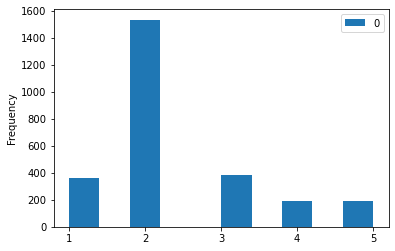

In [39]:
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)
import pandas as pd

df = pd.DataFrame(y)
df.plot.hist(xticks=[1, 2, 3, 4, 5])


In [18]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(np.mean(y_pred == y_test))

print(confusion_matrix(y_test, y_pred))

0.4431235991034262
[[ 6536  8422  3335   384  1195]
 [ 2443 15609  1157   213   739]
 [ 6296  8590  3493   366  1159]
 [  795   407   163  7147 11538]
 [  788   413   154  7095 11499]]


In [23]:
x_test.shape

(99936, 312)

In [19]:
from sklearn.linear_model import LogisticRegression
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
clf = LogisticRegression(random_state=0)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(np.mean(y_pred == y_test))

print(confusion_matrix(y_test, y_pred))

0.5249759846301633
[[ 8427  2157  8160   573   555]
 [ 1240 17073  1256   269   323]
 [ 8192  2159  8419   523   611]
 [  651   405   475  9285  9234]
 [  677   374   514  9124  9260]]


/home/bao/anaconda3/envs/dota/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split


# for hero, train a logistic regression model and add to VotingClassifier
estimators = []


clf = LogisticRegression(multi_class='multinomial', random_state=1)

eclf1 = VotingClassifier(estimators=estimators, voting='hard')
eclf1 = eclf1.fit(x_train, y_train)

ValueError: Invalid 'estimators' attribute, 'estimators' should be a list of (string, estimator) tuples.

In [ ]:
print(eclf1.predict(x_test))

NameError: name 'eclf1' is not defined

In [ ]:
np.array_equal(eclf1.named_estimators_.lr.predict(x), eclf1.named_estimators_['lr'].predict(x))

NameError: name 'np' is not defined